In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import numpy.linalg as la
import scipy.linalg as sla
import scipy.sparse as sp
import scipy.sparse.linalg as spla

# Norms

In [5]:
v = np.random.rand(10)
print(v)

p = 5

print(la.norm(v,p))

normv = 0
for vi in v:
    normv += abs(vi)**p
normv = normv**(1/p)

print(normv)

[0.36648243 0.47036164 0.31253997 0.57639159 0.69500335 0.68270278
 0.68837841 0.59646451 0.47898418 0.97769541]
1.0923555965090863
1.0923555965090863


In [7]:
n = 10

A = np.random.rand(n,n)
print(A.shape)

v = np.random.rand(n)
print(v.shape)

p = 2


normv = 0
for vi in v:
    normv += abs(vi)**p
normv = normv**(1/p)

Av = A@v

normAv = la.norm(Av,p)

print(normAv/normv, la.norm(A,2))

(10, 10)
(10,)
3.9070307801701936 5.08048550511338


In [12]:
n = 10

A = np.random.rand(n,n)
print(A.shape)

normA = 0

p = 2

for i in range(100000):
    
    v = np.random.rand(n)

    normv = 0
    for vi in v:
        normv += abs(vi)**p
    normv = normv**(1/p)

    Av = A@v

    normAv = la.norm(Av,p)
    
    normAtemp = normAv/normv
    
    if normAtemp > normA:
        normA = normAtemp

print(normA, la.norm(A,2))

(10, 10)
5.315537209920713 5.34272931358472


# Norms to quantify errors

In [13]:
u = np.array([1,0])
v = np.array([1,0.1])

e = v-u
la.norm(e,2)

0.1

In [14]:
la.norm(v)

1.004987562112089

In [15]:
la.norm(u)

1.0

# Be careful with the default settings

https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html

In [16]:
n = 3

A = np.random.randint(10, size=(n,n))
print(A)



[[6 4 8]
 [8 7 4]
 [5 5 5]]


# Solve Linear System of Equations

![](myfigure.png)

When performing optimization of structural problem, for example to obtain the bridge design above, you may want to use a numerical method called Finite Element Method (you will learn this in a future MP). The optimization will consist of a series of `solve` of the form:
$$ {\bf K} {\bf u} = {\bf F} $$

Here will load the matrix $ {\bf K}$ from a file. The matrix is given in Compressed Sparse Column (CSC) format.

In [17]:
K = sp.load_npz('yourmatrix.npz')
K

<6600x6600 sparse matrix of type '<class 'numpy.float64'>'
	with 105912 stored elements in Compressed Sparse Column format>

We can `spy` the distribution of the non-zero entries of the matrix:

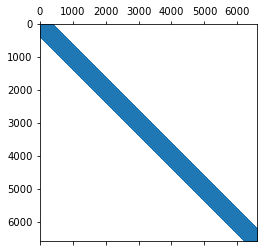

In [18]:
plt.spy(K)
plt.show()

The matrix ${\bf K}$ has a banded format, and it is also symmetric and positive definite. 

In [19]:
Kdense = K.todense()

In [20]:
Kdense.shape

(6600, 6600)

### Solving the linear system of equations using different methods:

In [21]:
F = np.zeros(K.shape[0])
F[1]=-1

#### a) la.solve

In [22]:
u1 = sla.solve(Kdense,F)
u1.shape

(6600,)

#### b) LU factorization

In [23]:
P,L,U = sla.lu(Kdense)
y = sla.solve_triangular(L, np.dot(P.T, F), lower=True)
u2 = sla.solve_triangular(U, y)
u2.shape

(6600,)

#### c) Cholesky factorization

In [24]:
Kcho = sla.cholesky(Kdense)
u3 = sla.cho_solve((Kcho,False),F)
u3.shape

(6600,)

#### d) Sparse solve

In [25]:
u4 = spla.spsolve(K,F)
u4.shape

(6600,)

# What is happening inside "solve"?

Inside "Solve" there are factorization and substitutions. For example, let's think of LU factorization.

We want to solve $Ax = P L U x = b$. We perform the following steps:

1. Factorize $A = P L U$
2. $y \leftarrow \text{solve}\,\, L y = P^Tb$
3. $x \leftarrow \text{solve}\,\, U x = y$

## Why do we split the factorization and substitutions?

In [26]:
F = np.zeros(K.shape[0])
F[1]=-10
F[0]=5

In [27]:
sla.solve(Kdense,F)

array([-459.314442  , -475.51384278, -468.07847515, ...,  119.77705961,
        -11.59014506,  138.47099828])

In [28]:
P, L, U = sla.lu(Kdense)

y = sla.solve_triangular(L, P.T@F, lower=True)

sla.solve_triangular(U, y)

array([-459.314442  , -475.51384278, -468.07847515, ...,  119.77705961,
        -11.59014506,  138.47099828])

# Simple example


$$
Ax = \begin{bmatrix}c&1\\-1&1\end{bmatrix}\begin{bmatrix}x_1\\x_2\end{bmatrix}
=
\begin{bmatrix}b_1\\b_2\end{bmatrix}
$$
with an exact solution of
$$
x_{exact} = \begin{bmatrix}1\\1\end{bmatrix}
$$

In [29]:
def myLU(A): 
    M = A.copy()
    for i in range(A.shape[0]):
        M[i+1:,i] = M[i+1:,i]/M[i,i]
        M[i+1:,i+1:] -= np.outer(M[i+1:,i],M[i,i+1:]) 
    return M

In [34]:
# Creating the arrays
c =  1e-16
A = np.array([[c, 1.], [-1, 1]])
# xx is the exact solution
xx = np.array([1,1])
b = A.dot(xx)

# Comput the LU
M = myLU(A)
L = np.tril(M,-1) + np.eye(2,2)
U = np.triu(M)

# Solve
# x is the numerical (xhat)
y = sla.solve_triangular(L, b, lower=True)
x = sla.solve_triangular(U, y)


print("Exact solution = ", xx)

print("Computed solution = ",x)

print("Error = ", la.norm(xx-x))


Exact solution =  [1 1]
Computed solution =  [0. 1.]
Error =  1.0


Is the matrix A singular?

A) YES

B) NO


In [37]:
la.solve(A,b)

array([1., 1.])

In [36]:
la.det(A)

1.0